In [1]:

import os
import pdb
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
import torch.nn as nn
import random
import copy
import ipdb

# Pipelines (a.k.a parts of the Neural Network)
from Pipelines.kitti_loader import KITTIDataset
from Pipelines.pillarizer import PillarFeatureNet, Pillarization, PseudoImageDataset
from Pipelines.backbone import BackBone
from Pipelines.detection_head import DetectionHead
from Pipelines.anchors import Box2D, Anchor
from Pipelines.loss import PointPillarLoss

from Utils.transformations import transform_to_canvas, transform_to_grid, map_to_img
from Utils.iou import calculate_iou
from Utils.collate import normalize_annotations
from Utils.boxes import create_boxes_tensor # FIXME: Should be in visualization instead

# Visualization tools:
from Visualization.visz_pointcloud_w_label import plot_point_cloud_with_bboxes_o3d
from Visualization.visz_bboxes import visualize_batch_bounding_boxes


# Some Neural Network Parameters:
AUG_DIM = 9
MAX_POINTS_PER_PILLAR = 100
MAX_FILLED_PILLARS = 12000
X_MIN = 0.0
X_MAX = 70.4
Y_MIN = -40.0
Y_MAX = 40.0
Z_MIN = -3.0
Z_MAX = 1.0
PILLAR_SIZE = (0.16, 0.16)
DESIRED_CLASSES = ['Car'] # More classes can be added here
SCALE_FACTOR = 1.5
H = 500
W = 440


ANCHORS = torch.tensor([[3.9, 1.6, 1.56, -1, 0], # Anchors as tensor: (height, width, height, z_center, orientation)
                       [1.6, 3.9, 1.56, -1, 1.5708],
                       [0.8, 0.6, 1.73, -0.6, 0],
                       [0.6, 0.8, 1.73, -0.6, 1.5708]]
                       )

mapped_anchors = ANCHORS.detach().clone()
mapped_anchors[:,0:2] /= PILLAR_SIZE[0]


# Define a dictionary to map attributes to their indices
attributes_idx = {
    'norm_x': 7,
    'norm_y': 8,
    'norm_z': 9,
    'norm_h': 10,
    'norm_w': 11,
    'norm_l': 12,
}

for anchor_tensor in mapped_anchors: # NOTE: This is regardless of the batch, it is for all the training and testing
    anchor = Anchor(width=anchor_tensor[1], height=anchor_tensor[0])
    anchor.create_anchor_grid(H,W) # Creates grid
    anchor.create_anchors()
    break # FIXME: Get rid of this
    #anchors_list.append(anchor)



print(f'Can I can use GPU now? -- {torch.cuda.is_available()}')


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Can I can use GPU now? -- True


Load data from the KITTI dataset and perform train-test split:


In [2]:
train_pointclouds_dir = '/home/adlink/Documents/ECE-57000/ClassProject/Candidate2/PointPillars/dataset/kitti/training/velodyne_reduced'
train_labels_dir = '/home/adlink/Documents/ECE-57000/ClassProject/Candidate2/PointPillars/dataset/kitti/training/label_2'
test_pointclouds_dir = '/home/adlink/Documents/ECE-57000/ClassProject/Candidate2/PointPillars/dataset/kitti/testing/velodyne_reduced'

train_set = KITTIDataset(pointcloud_dir=train_pointclouds_dir, labels_dir=train_labels_dir)

# TODO: Add Loader for test set (No labels)




Visualize a pointcloud with its annotations

In [3]:
# Example usage:
random_idx_sample = random.randint(0,7000)
point_cloud, labels_to_show = train_set[0]  # TODO: Is it necessary to rotate bounding box 90 deg?
geometries = plot_point_cloud_with_bboxes_o3d(point_cloud.numpy(), labels_to_show)

File loaded: /home/adlink/Documents/ECE-57000/ClassProject/Candidate2/PointPillars/dataset/kitti/training/velodyne_reduced/006066.bin


/home/adlink/Documents/ECE-57000/ClassProject/github/PointPillars/Implementation/Pipelines/kitti_loader.py:50: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return torch.from_numpy(point_cloud)


Batch data:

In [3]:
# IMPORTANT: Set to CPU for pillarization otherwise, expect GPU memory to overflow
device =  torch.device('cpu')

# Create a collate function to handle variable-sized labels:
def collate_batch(batch):
    point_clouds, annotations = zip(*batch)
    point_clouds = torch.stack(point_clouds, dim=0)
    
    normalized_annotations = normalize_annotations(annotations, pillar_size=PILLAR_SIZE,
        x_lims=(X_MIN, X_MAX), y_lims=(Y_MIN, Y_MAX))
    
    return point_clouds, normalized_annotations


        
# Create the dataset and DataLoader
dataset = PseudoImageDataset(pointcloud_dir=train_pointclouds_dir, device=device, kitti_dataset=train_set, aug_dim=AUG_DIM, max_points_in_pillar=MAX_POINTS_PER_PILLAR,
                             max_pillars=MAX_FILLED_PILLARS, x_min=X_MIN, y_min=Y_MIN, z_min=Z_MIN, x_max = X_MAX, y_max=Y_MAX,
                             z_max = Z_MAX, pillar_size=PILLAR_SIZE)

train_loader = DataLoader(dataset, batch_size=4, shuffle=False, collate_fn=collate_batch) # FIXME: Set batch to 4 again


# Iterate through batches:  
for batch_idx, (pseudo_images, batched_labels) in enumerate(train_loader):
    break # TODO: Erase this and pass the entire dataset

/home/adlink/Documents/ECE-57000/ClassProject/github/PointPillars/Implementation/Pipelines/kitti_loader.py:50: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  return torch.from_numpy(point_cloud)


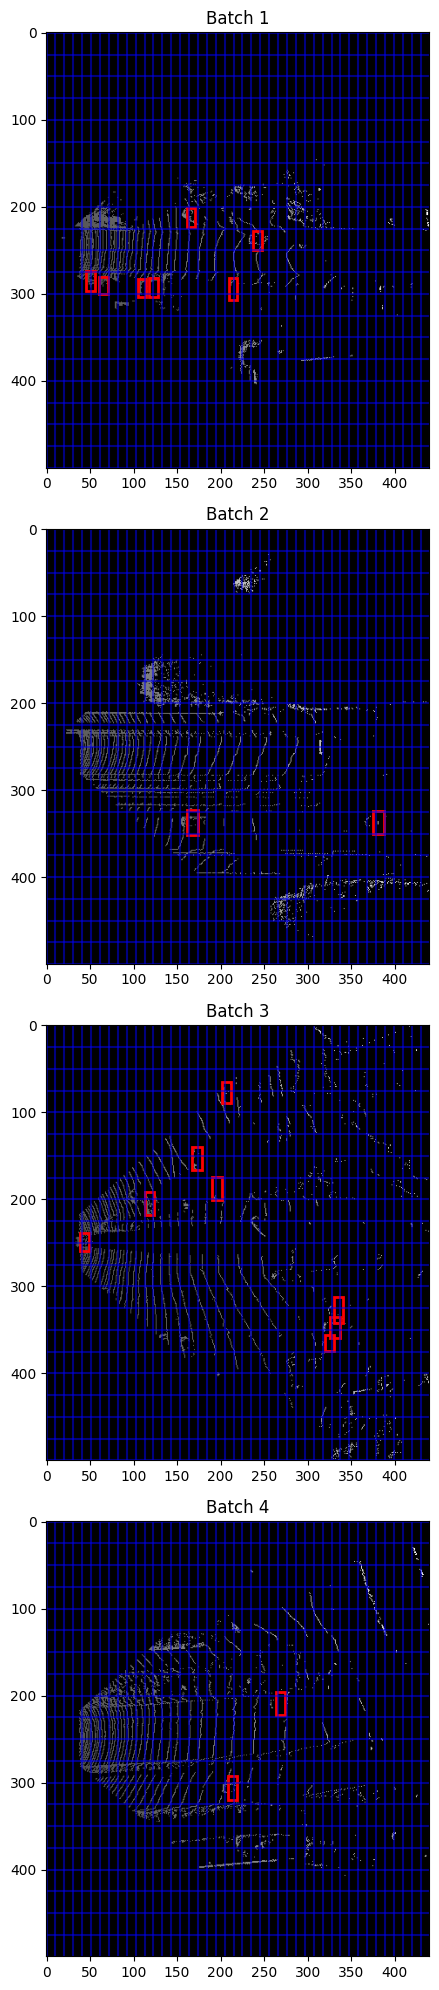

In [4]:


#TODO: Uncomment Me!
#anchors_list = [] 
#roi_boxes_tensor = anchor.generate_ROI_boxes(gt_boxes_tensor=gt_boxes_tensor, 
#            scale_factor=SCALE_FACTOR) # Size (bs, n_obj, (x_min, y_min, x_mx, y_max)) (4, 8,4)


# Ground truth tensor of size (bs, n_boxes, 4)
gt_boxes_tensor = create_boxes_tensor(batched_labels, attributes_idx)

# Get the roi indices:
roi_indices = anchor.get_ROI_indices(gt_boxes_tensor=gt_boxes_tensor, scale_factor=1.5, 
            feature_map_size=(H,W))


# Get IoU tensor and regression targets:
iou_tensor = anchor.calculate_batch_iou(gt_boxes_tensor) 
'''IoU tensor (batch_size, n_boxes, num_anchors_x, num_anchors_y)'''


regression_targets_tensor = anchor.get_regression_targets_tensor(iou_tensor, (H,W), threshold=0.5)


classification_targets_dict = anchor.get_classification_targets(iou_tensor=iou_tensor, feature_map_size=(H,W),
                            background_lower_threshold=0.05, background_upper_threshold=0.25)
'''A dictionary with keys as batch indices and values as lists of (box_index, 
feature_map_x_index, feature_map_y_index, class_label)'''


visualize_batch_bounding_boxes(feature_maps=pseudo_images, boxes_tensor=gt_boxes_tensor, 
                               attributes_idx=attributes_idx, visz_anchor=True, anchor=anchor)


In [5]:
gt_boxes_tensor[0]

tensor([[ 45.4688, 274.0000,  56.0312, 297.0000],
        [ 60.7812, 280.1562,  70.4688, 300.2188],
        [105.5938, 283.4688, 114.7812, 303.6562],
        [117.9688, 281.5625, 127.7812, 303.1875],
        [161.0625, 200.8750, 170.8125, 222.6250],
        [237.7812, 227.8438, 247.2188, 249.4062],
        [209.1250, 282.1562, 219.3750, 307.2188],
        [  0.0000,   0.0000,   0.0000,   0.0000]])

In [6]:
regression_targets_tensor


tensor([[[ 50, 261],
         [ 60, 285],
         [110, 285],
         [120, 285],
         [160, 190],
         [240, 238],
         [210, 285],
         [  0,   0]],

        [[160, 309],
         [370, 309],
         [  0,   0],
         [  0,   0],
         [  0,   0],
         [  0,   0],
         [  0,   0],
         [  0,   0]],

        [[ 40, 238],
         [320, 333],
         [320, 357],
         [330, 309],
         [170, 142],
         [120, 190],
         [190, 166],
         [200,  71]],

        [[210, 285],
         [260, 190],
         [430,  71],
         [  0,   0],
         [  0,   0],
         [  0,   0],
         [  0,   0],
         [  0,   0]]])

In [5]:
# After pillarization and batching, we can start using the GPU:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Backbone pipeline:

Text(0.5, 1.0, 'Features Summed Over Channels')

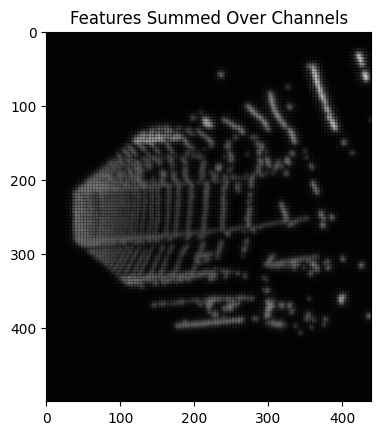

In [6]:
# Forward pass through the backbone:

backbone = BackBone(in_channels=64, out_channels=64, device=device)
backbone_features = backbone(pseudo_images)


# Sum over channels for the original features
backbone_raw = torch.sum(backbone_features[3, :, :, :], dim=0).detach().numpy() # FIXME: Hardcoded batch_size
plt.imshow(backbone_raw, cmap='gray')
plt.title('Features Summed Over Channels')

In [ ]:
list(backbone.parameters())

Now, implement the Detection Head:

In [7]:
#backbone_output = torch.randn(4, backbone_features.size()[1], 252, 252) # Example feature map from backbone
detection_head = DetectionHead(device=device, in_channels=backbone_features.size()[1], grid_size_x=backbone_features.size()[2], 
                        grid_size_y=backbone_features.size()[3], num_anchors=1, num_classes=2) #TODO: Initialize with correct parameters
loc, size, clf, occupancy, angle, heading = detection_head(backbone_features)

In [8]:
loc.size()

torch.Size([4, 1, 3, 500, 440])

In [11]:
backbone_features.size()

torch.Size([4, 384, 500, 440])

In [8]:

criterion = PointPillarLoss()

loss = criterion(regression_targets=regression_targets_tensor, 
        classification_targets_dict=classification_targets_dict,
        gt_boxes_tensor = gt_boxes_tensor, loc=loc, size=size,
        clf=clf, occupancy=occupancy, angle=angle, heading=heading,
        anchor=anchor)





In [15]:
loc.size()

torch.Size([4, 1, 3, 500, 440])